In [41]:
import pandas as pd
import numpy as np
import scipy as sp
from functools import partial
from math import sqrt
from collections import Counter


In [1]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [4]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [22]:
train = pd.read_csv("../data/train/train.csv")
target = train['AdoptionSpeed']
train.drop(['Name', 'RescuerID', 'AdoptionSpeed', 'Description', 'PetID'], axis=1, inplace=True)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=1234)

In [25]:
from sklearn.linear_model import LinearRegression

In [32]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
preds = LR_model.predict(X_test)

In [36]:
optR = OptimizedRounder()
optR.fit(preds, y_test)

In [37]:
coeff = optR.coefficients()
pred_test_coeff = optR.predict(preds, coeff)

In [39]:
pred_test_coeff

array([2., 2., 2., ..., 2., 4., 3.])

In [43]:
quadratic_weighted_kappa(y_test, pred_test_coeff)

0.2124256947116976

In [46]:
len(LR_model.coef_)

19

Feature 0 (Type):, Score: -0.12413
Feature 1 (Age):, Score: 0.00966
Feature 2 (Breed1):, Score: 0.00293
Feature 3 (Breed2):, Score: 0.00019
Feature 4 (Gender):, Score: 0.09784
Feature 5 (Color1):, Score: -0.03352
Feature 6 (Color2):, Score: -0.00678
Feature 7 (Color3):, Score: -0.00791
Feature 8 (MaturitySize):, Score: 0.06599
Feature 9 (FurLength):, Score: -0.19328
Feature 10 (Vaccinated):, Score: -0.14136
Feature 11 (Dewormed):, Score: 0.12012
Feature 12 (Sterilized):, Score: -0.11771
Feature 13 (Health):, Score: 0.13022
Feature 14 (Quantity):, Score: 0.03509
Feature 15 (Fee):, Score: 0.00030
Feature 16 (State):, Score: 0.00081
Feature 17 (VideoAmt):, Score: 0.00739
Feature 18 (PhotoAmt):, Score: -0.00962


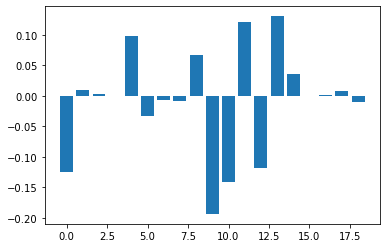

,Coefficient,Feature
9,-0.193282,FurLength
10,-0.141356,Vaccinated
13,0.130219,Health
0,-0.124133,Type
11,0.120116,Dewormed
12,-0.117713,Sterilized
4,0.097838,Gender
8,0.065991,MaturitySize
14,0.035092,Quantity
5,-0.033516,Color1


In [69]:
import matplotlib.pyplot as plt
importance = LR_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature {i:0d} ({train.columns[i]}):, Score: {v:.5f}')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

importance_df = pd.DataFrame([importance]).transpose()
importance_df.columns = ['Coefficient']
importance_df['Feature'] = train.columns
importance_df.reindex(importance_df.Coefficient.abs().sort_values(ascending=False).index)

In [86]:
test = pd.read_csv("../data/test/test.csv")
test_id = test['PetID']
print(test.columns)
test.drop(['RescuerID', 'Name', 'Description', 'PetID'], axis=1, inplace=True)
final_preds_num = LR_model.predict(test)
final_preds_cat = optR.predict(final_preds_num, coeff)
final_preds_cat

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt'],
      dtype='object')


array([2., 4., 2., ..., 4., 3., 3.])

In [87]:
submission = pd.DataFrame({'PetID': test_id, 'AdoptionSpeed': final_preds_cat})
submission.head()

,PetID,AdoptionSpeed
0,e2dfc2935,2.0
1,f153b465f,4.0
2,3c90f3f54,2.0
3,e02abc8a3,4.0
4,09f0df7d1,2.0


In [88]:
submission.to_csv('submission.csv', index=False)